<a href="https://colab.research.google.com/github/GOTWIC/AI-Chess-Engine/blob/main/Chess_Engine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [ ]:
# Basic Libraries
import time
import pprint
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Analysis and Data Libraries
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

# Regression Libraries
import xgboost as xgb
from sklearn import linear_model
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

# Neural Network Libraries
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.metrics import MeanAbsoluteError
from keras.utils.vis_utils import plot_model


# Special Libraries
import chess

# Misc Libraries
import gc
from google.colab import drive
from IPython.display import clear_output 

# Misc Other
! rm -rf sample_data

# Import Original Dataset and Reformat to Custom Dataframe (Not Recommended)

The steps in this section achieve the following:
1. Import the Original Kaggle dataset
2. Load the Dataset into a dataframe
3. Parse and Reformat the dataframe for all 13 million positions into a new dataframe
4. Upload new dataframe to Google Drive as a .CSV file.

Because reformatting 13 million chess positions is incredibly resource intensive, it's better to download the reformatted .CSV file that is generated at the end of this process. Using the reformatted .CSV file will significantly reduce the setup time for subsequent sessions.



### *If you want to download the reformatted .CSV file:*
*It is better to save the reformatted file to drive and download from there (10 minutes total), rather than save the file to colab's local storage and download directly from here (20 minutes or more).*

## Import Dataset 

1.   Download Kaggle API .json file
2.   Upload to Google Drive (root folder)
3.   Mount Google Drive



In [ ]:
! pip install kaggle
! mkdir ~/.kaggle
! cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download ronakbadhe/chess-evaluations
! unzip chess-evaluations.zip

## Load and Read Dataset

In [ ]:
path = 'chessData.csv' 
rawData = pd.read_csv(path)

## Parse FEN + Evaluation into Custom Data Frame

The original data frame includes only two columns: the FEN and the Evaluation. To prepare the dataset for inputting, we need to reformat the input. The reformatting parses the FEN string and allocates a column for every square on the board (64 squares), and an additional column for the evaluation (65 columns in total).

***This step will take around 18 minutes to complete.***

In [ ]:
def parsePiece(piece):
  return {
        'P': 1,
        'N': 2,
        'B': 3,
        'R': 4,
        'Q': 5,
        'K': 6,
        'p': -1,
        'n': -2,
        'b': -3,
        'r': -4,
        'q': -5,
        'k': -6,
    }[piece]

rows = len(rawData)
rawParse = np.empty([rows, 65])

for row in range(rows):
  FENIndex = 0
  for char in rawData.FEN[row]:
    if char.isalpha():
      rawParse[row][FENIndex] = parsePiece(char)
      FENIndex += 1
    elif char.isdigit():
      for emptySpace in range(int(char)):
        rawParse[row][FENIndex] = 0
        FENIndex += 1
    elif char == ' ':
      break

  eval = rawData.Evaluation[row]
  if eval[0] == '+':
    rawParse[row][64] = int(eval[1:])
  elif eval[0] == '-':
    rawParse[row][64] = -1 * int(eval[1:])
  elif eval[0] == '#':
    if eval[1] == '+':
      rawParse[row][64] = 32000
    elif eval[1] == '-':
      rawParse[row][64] = -32000
  else:
    rawParse[row][64] = 0

  if row%100000 == 0:
    print("Currently reformatting position #" + str(row))

print("Finished processing " + str(rows) + " positions")
  

squareLabels = []
for i in range(1, 9):
  for j in range(1, 9):
    squareLabels.append(chr(j + 96) + chr((8-i) + 49))
squareLabels.append('Evaluation')

data = pd.DataFrame(rawParse, columns = squareLabels)
downcasted_data = data.apply(pd.to_numeric,downcast='signed')

print("Reformatting Complete")





## Delete the Original Dataframe
Reformatting pretty much deletes all of your ram. This step will free up some memory space.

In [ ]:
del rawData
del data
gc.collect()

## Save New Dataframe as a .CSV file and download to Google Drive
After this step, you can import the new dataframe directly from Google Drive.

In [ ]:
path = '/content/drive/My Drive/ReformattedChessDataset.csv'
with open(path, 'w', encoding = 'utf-8-sig') as f:
  downcasted_data.to_csv(f)

# The Reformatted Dataset

## Import Dataset 

1.   Download Kaggle API .json file
2.   Upload to Google Drive (root folder)
3.   Mount Google Drive

*Runtime: Approximately 30 seconds*

In [ ]:
! pip install kaggle
! mkdir ~/.kaggle
! cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download swagnikroychoudhury/bysquare-chess-evaluations
! unzip bysquare-chess-evaluations.zip

 94% 153M/163M [00:01<00:00, 126MB/s]
100% 163M/163M [00:01<00:00, 127MB/s]
Archive:  bysquare-chess-evaluations.zip
  inflating: ReformattedChessDataset.csv  


## Loading the Dataset

Although the reformatted dataset has been optimized, numbers (float/int) are converted to the 64-bit version when the dataframe is converted to a .CSV file. In other words, most of the optimizations are gone. We need to chunk, downcast, and concatonate the dataset to re-optimize it.

Most of the table values are of the data type INT8. Converting the dataframe into a .csv file converts the INT8 to INT64, thus taking up 8x more memory. This is okay for small datasets, but because this dataset is so big, Colab crashes with the INT64 datatype.

*Runtime: Approximately 1 minute*

In [ ]:
path = 'ReformattedChessDataset.csv' 
chunksize = 1000000
data = pd.DataFrame()

for count, chunk in enumerate(pd.read_csv(path, chunksize=chunksize)):
  print("Processing Chunk " + str(count + 1))
  data = pd.concat([data, chunk.apply(pd.to_numeric,downcast='signed')]).select_dtypes(include=['int8', 'int16'])

print("Chunk Processing Complete")

Processing Chunk 1
Processing Chunk 2
Processing Chunk 3
Processing Chunk 4
Processing Chunk 5
Processing Chunk 6
Processing Chunk 7
Processing Chunk 8
Processing Chunk 9
Processing Chunk 10
Processing Chunk 11
Processing Chunk 12
Processing Chunk 13
Chunk Processing Complete


## Preparing the Dataset

The following code generates a sample of the dataset to test different types of models. When the right model/network has been selected, the entire data set will be used to train the final model.

In [ ]:
labels = []
for i in range(1, 9):
  for j in range(1, 9):
    labels.append(chr(j + 96) + chr((8-i) + 49))

sample = data.sample(n = 2000000)

y = sample.Evaluation
X = sample[labels]
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state = 0)

# Part 1: Regressional Machine Learning
The next section uses various regressional models. While the models are not parametrically tuned, there is no point in doing so as it becomes apparent soon that regressional analysis does not work well, or at all. 

### Linear Regression


In [ ]:
linear_model = linear_model.LinearRegression()
linear_model.fit(X_train, y_train)
pred = linear_model.predict(X_val)
print("Mean Absolute Error: ", mean_absolute_error(y_val, pred))

Mean Absolute Error:  1129.7312063645802


In [ ]:
y_val_arr = y_val.to_numpy()
error_statistics = pd.DataFrame(abs(pred - y_val_arr))
error_statistics.describe()

,0
count,250000.000000
mean,1129.731206
std,3777.202189
min,0.005231
25%,203.619112
50%,458.892826
75%,879.547302
max,36331.179984


### Ridge Model

In [ ]:
ridge_model = linear_model.Ridge()
ridge_model.fit(X_train, y_train)
pred = ridge_model.predict(X_val)
print("Mean Absolute Error: ", mean_absolute_error(y_val, pred))

Mean Absolute Error:  1099.8443733035333


In [ ]:
y_val_arr = y_val.to_numpy()
error_statistics = pd.DataFrame(abs(pred - y_val_arr))
error_statistics.describe()

,0
count,250000.000000
mean,1099.844373
std,3713.113814
min,0.003003
25%,199.742152
50%,447.053868
75%,855.979286
max,36671.500247


### Random Forest Regression

In [ ]:
forest_model = RandomForestRegressor(max_leaf_nodes=2, n_estimators=1, random_state=1)
forest_model.fit(X_train, y_train)
pred = forest_model.predict(X_val)
print("Mean Absolute Error: ", mean_absolute_error(y_val, pred))

Mean Absolute Error:  795.9841577381966


In [ ]:
y_val_arr = y_val.to_numpy()
error_statistics = pd.DataFrame(abs(pred - y_val_arr))
error_statistics.describe()

,0
count,250000.000000
mean,798.419547
std,3862.555332
min,0.165694
25%,63.165694
50%,122.834306
75%,316.165694
max,33668.823388


### XGBoost

In [ ]:
xgb_model = xgb.XGBRegressor(objective='reg:squarederror')
xgb_model.fit(X_train, y_train)
pred = xgb_model.predict(X_val)
print("Mean Absolute Error: ", mean_absolute_error(y_val, pred))

Mean Absolute Error:  837.26324


In [ ]:
y_val_arr = y_val.to_numpy()
error_statistics = pd.DataFrame(abs(pred - y_val_arr))
error_statistics.describe()

,0
count,250000.000000
mean,837.254761
std,3760.269775
min,0.000954
25%,59.134232
50%,159.506027
75%,440.687271
max,36464.964844


# Part 2: Deep Learning
Since standard regressional models did not work, we turn to deep learning.

There are different types and subtypes of Neural Networks. In our case, it makes the most sense to use a Feed-Forward Network (FFN). There are different types of FFNs, but for our first experiment we will try Multilayer Perceptron (MLP).

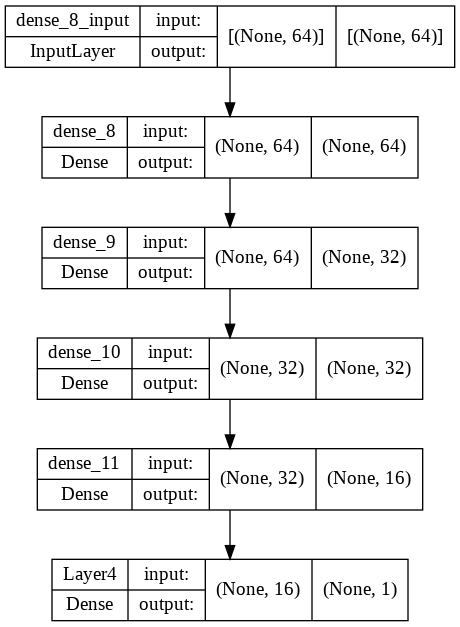

In [ ]:
mlp_model = keras.Sequential(
    [
        layers.Dense(64, input_dim=64, activation="relu"),
        layers.Dense(32, activation="relu"),
        layers.Dense(32, activation="relu"),
        layers.Dense(16, activation="relu"),
        #layers.Dropout(0.2),
        #layers.Dense(128, activation="relu"),
        layers.Dense(1, name="Layer4")
    ]
) 


mlp_model.compile(loss="mse", optimizer="adam", metrics=[MeanAbsoluteError()])

K.set_value(mlp_model.optimizer.learning_rate, 0.0001)

plot_model(mlp_model, show_shapes=True, show_layer_names=True)

In [ ]:
mlp_model.fit(X_train, y_train, epochs=150, batch_size=1000, verbose=2, validation_data=(X_val, y_val))

Epoch 1/20
1500/1500 - 11s - loss: 14392901.0000 - mean_absolute_error: 1016.6736 - val_loss: 13468813.0000 - val_mean_absolute_error: 1076.1857 - 11s/epoch - 7ms/step
Epoch 2/20
1500/1500 - 6s - loss: 13415393.0000 - mean_absolute_error: 1020.3499 - val_loss: 13307756.0000 - val_mean_absolute_error: 1008.7700 - 6s/epoch - 4ms/step
Epoch 3/20
1500/1500 - 6s - loss: 13295410.0000 - mean_absolute_error: 1008.6697 - val_loss: 13251001.0000 - val_mean_absolute_error: 992.1784 - 6s/epoch - 4ms/step
Epoch 4/20
1500/1500 - 7s - loss: 13238100.0000 - mean_absolute_error: 1003.7100 - val_loss: 13221125.0000 - val_mean_absolute_error: 1000.7441 - 7s/epoch - 4ms/step
Epoch 5/20
1500/1500 - 7s - loss: 13202144.0000 - mean_absolute_error: 1003.8914 - val_loss: 13234841.0000 - val_mean_absolute_error: 995.8565 - 7s/epoch - 5ms/step
Epoch 6/20
1500/1500 - 7s - loss: 13173424.0000 - mean_absolute_error: 1001.8900 - val_loss: 13200073.0000 - val_mean_absolute_error: 986.1799 - 7s/epoch - 5ms/step
Epoch

In [ ]:
#print(mlp_model.history)

plt.plot(mlp_model.history['acc'])
plt.plot(mlp_model.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

TypeError: ignored

# The Chess Board

The following section is a way to interact with the chess evaluator.

In [ ]:
board = chess.Board()

def parsePiece(piece):
  return {
        'P': 1,
        'N': 2,
        'B': 3,
        'R': 4,
        'Q': 5,
        'K': 6,
        'p': -1,
        'n': -2,
        'b': -3,
        'r': -4,
        'q': -5,
        'k': -6,
    }[piece]

def parseFEN(FEN):
  FENIndex = 0
  parsed = np.empty([1, 64])
  for char in FEN:
    if char.isalpha():
      parsed[0][FENIndex] = parsePiece(char)
      FENIndex += 1
    elif char.isdigit():
      for emptySpace in range(int(char)):
        parsed[0][FENIndex] = 0
        FENIndex += 1
    elif char == ' ':
      break
  return pd.DataFrame(parsed, columns=labels)

In [ ]:
board.reset()

In [ ]:

print(board)

for i in range(1,501):

  human_move = input("Your Move: ")

  if human_move == "/e":
    break

  board.push_san(human_move)

  clear_output()

  maxEval = 0
  move_to_play = chess.Move

  for uci in board.legal_moves:
    move = chess.Move.from_uci(str(uci))
    board.push(move)
    FEN = board.fen()
    move_df = parseFEN(FEN)
    pred = abs(mlp_model.predict(move_df))
    board.pop()

    print(pred[0])

    if pred[0] > maxEval:
      maxEval = pred[0]
      move_to_play = move
    
    if pred[0] == maxEval:
      pick = random.randrange(2)
      if pick == 0:
        move_to_play = move
    
  board.push(move_to_play)

  print(board)
  print(board.fullmove_number)

  if board.is_game_over():
    break

board

#board.outcome()


In [ ]:

for i in range(1,10):

  maxEval = 0
  move_to_play = chess.Move

  for uci in board.legal_moves:
    move = chess.Move.from_uci(str(uci))
    board.push(move)
    FEN = board.fen()
    move_df = parseFEN(FEN)
    pred = abs(mlp_model.predict(move_df))
    board.pop()

    #print(pred[0])

    if pred[0] > maxEval:
      maxEval = pred[0]
      move_to_play = move
    
    if pred[0] == maxEval:
      pick = random.randrange(2)
      if pick == 0:
        move_to_play = move
    
  board.push(move_to_play)

  clear_output()

  print(board.fullmove_number)

  if board.is_game_over():
    break

board



#board.outcome()


14


'♜ · ♝ ♛ ♚ ♝ · ♜\n♗ · · ♟ ♟ ♟ · ·\n♞ · · · · · ♕ ·\n· · ♟ · ♙ · · ♟\n· ♟ ♙ · · ♟ · ♙\n· · · ♙ · · · ·\n♙ ♙ · · · ♙ ♙ ·\n♖ · · ♔ · ♗ ♘ ♖'

In [ ]:
if chess.white():
  print("HI")

else:
  print("BYE")

AttributeError: ignored